MOTIVATION

Detailed simulation of qubit-cavity coupling with two-photon sideband transitions to verify the simplified simulation of the cQED atomic beam experiment.

NOTES

- 1 ns unit for time
- Conventions:
  - [qubit, resonator ]
  - Qubit: blue
  - Resonator: red

VALUES
- N = 2
    - Single tone
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ 1.2974 * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ 5.348 * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
    - Two tones
        - Red sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : wsb ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : wsb ~ ??? * 2 * pi
- N = 3
    - Single tone
        - Red sideband transitions
            - wq = 6.5, wc = 4 : shift ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : shift ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : shift ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : shift ~ ??? * 2 * pi
    - Two tones
        - Red sideband transitions
            - wq = 6.5, wc = 4 : shift ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : shift ~ ??? * 2 * pi
        - Blue sideband transitions
            - wq = 6.5, wc = 4 : shift ~ ??? * 2 * pi
            - wq = 4, wc = 6.5 : shift ~ ??? * 2 * pi

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plots import *
from supports import *
from process import *
from calculate import *
from envelopes import *
from scan import *
from qutip import *
from ipywidgets import widgets
from IPython.display import display

home = "/home/student/thesis/"
options = Options()
options.store_states=True

In [8]:
Nq = 2   # number of levels in qubit
Nc = 10  # number of levels in resonator 1
Nt = 2   # number of drive tones

wq = 6.5 *2*pi     # qubit frequency
wc = 4 *2*pi       # resonator frequency
delta = wq - wc    # detuning
Ec = 0.16 *2*pi    # anharmonicity (charging energy)
g = 0.2 *2*pi      # coupling between qubit and resonator

if Nt == 1:
    Omega = 0.3 *2 *2*pi  # pump drive amplitude
    wd = 5.348 *2*pi      # pump drive frequency
    Stark_shift = Omega**2/(2*(wq-wd)) + Omega**2/(2*(wq+wd))  # ac-Stark shift
elif Nt == 2:
    Omegaq = 0.025 *2 *2*pi  # amplitude of qubit-friendly drive tone
    Omegac = 0.317 *2 *2*pi  # amplitude of cavity-friendly drive tone
    dw = 0.0662 *2*pi
    shift = 0.072 *2*pi  # ac-Stark shift
    wdq = wq + shift - dw  # frequency of qubit-friendly drive tone
    wdc = wc + shift + dw  # frequency of cavity-friendly drive tone
    Stark_shift = ( Omegaq**2/(2*(wq-wdq)) + Omegaq**2/(2*(wq+wdq)) + 
                    Omegac**2/(2*(wq-wdc)) + Omegac**2/(2*(wq+wdc)) )
sb = 'blue'  # kind of sideband transitions (required for plotting & saving)

print(Stark_shift)

-0.7001589527722445


In [18]:
t0 = 0         # start of simulation
t1 = t0 + 0   # start of drive
t2 = t1 + 200  # end of drive
t3 = t2 + 0   # end of simulation
tg = 10        # length of gaussian rise and fall

smooth = True  # whether or not to rise and fall with gaussian
Q = 3          # number of std's in gaussian rise and fall

Np = 100*int(t3)     # number of discrete time steps for which to store the output
print("timestep =", 1e3*np.round(t3/Np, 5), "ps")

timestep = 10.0 ps


In [19]:
# Operators
b, a, nq, nc = ops(Nq, Nc)

# Jaynes-Cummings Hamiltonian
Hjc = wq*nq + wc*nc - Ec/2*b.dag()*b.dag()*b*b
Hc = g*(a*b + a*b.dag() + b*a.dag() + a.dag()*b.dag())

# Sideband transitions
if Nt == 1:
    Hd = Omega*(b + b.dag())
elif Nt == 2:
    Hdq = Omegaq*(b + b.dag())
    Hdc = Omegac*(b + b.dag())

# Hamiltonian arguments
if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg,
              'Q'  : Q, 'smooth' : smooth, 'Nt' : Nt, 'wd' : wd}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg,
              'Q'  : Q, 'smooth' : smooth, 'Nt' : Nt, 'wdq' : wdq, 'wdc' : wdc}

# Expectation operators
e_ops = [nq, nc]

In [20]:
if Nt == 1:
    H = [Hjc, [Hc, drive_nonosc], [Hd, drive]]  # complete Hamiltonian
elif Nt == 2:
    H = [Hjc, [Hc, drive_nonosc], [Hdq, drive_qubit], [Hdc, drive_cavity]]  # complete Hamiltonian

psi0 = tensor(psi_0pi(Nq), basis(Nc, 0))  # initial state

# Select these options for bdf method
options.method = 'bdf'
options.rtol = 1e-10
options.atol = 1e-10

# Select these options for adams method
# options.nsteps = 1000
# options.rtol = 1e-12
# options.atol = 1e-12
# options.max_step = 0

Np_per_batch = Np/10  # number of time points per batch

In [21]:
""" CALCULATE! """

progfolder = calculate(H, psi0, e_ops, H_args, options, Nc, Np, Np_per_batch, verbose=True)

# Save parameters
if Nt == 1:
    saveparams(Nq, Nc, Nt, wq, wc, Ec, g, sb, t0, t1, t2, t3, tg, smooth, Q,
               Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'], Omega=Omega, wd=wd)
elif Nt == 2:
    saveparams(Nq, Nc, Nt, wq, wc, Ec, g, sb, t0, t1, t2, t3, tg, smooth, Q,
               Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'], Omegaq=Omegaq, Omegac=Omegac, wdq=wdq, wdc=wdc, dw=dw)

1 / 10 : 10 %
2 / 10 : 20 %
3 / 10 : 30 %
4 / 10 : 40 %
5 / 10 : 50 %
6 / 10 : 60 %
7 / 10 : 70 %
8 / 10 : 80 %
9 / 10 : 90 %
10 / 10 : 100 %
Evolution completed in 118.528233 s


In [22]:
""" SAVE EVOLUTION TEMPORARILY """

srcfolder =  progfolder #"/home/student/thesis/prog_190922_144723"
quants = ['times', 'expect', 'e0', 'g1', 'e1', 'g0']

start_comb = datetime.now()
new_folder_name = copy(srcfolder)
ID = getID(srcfolder)
combine_batches(srcfolder, quants=quants, return_data=False)
end_comb = datetime.now()
print("Batches combined    in {} s".format((end_comb - start_comb).total_seconds()))

times, states, expect, e0, g1, e1, g0 = load_data(quants, srcfolder)

Batches combined    in 2.061923 s


In [23]:
""" SIDEBAND COUPLING """

smoothen_method = 'savgol'

if 'eo' in quants:
    e0_macro, e0_macro_times = remove_micromotion(e0, times, method=smoothen_method)
if 'go' in quants:
    g0_macro, g0_macro_times = remove_micromotion(g0, times, method=smoothen_method)
if 'e1' in quants:
    e1_macro, e1_macro_times = remove_micromotion(e1, times, method=smoothen_method)
if 'g1' in quants:
    g1_macro, g1_macro_times = remove_micromotion(g1, times, method=smoothen_method)
if ('e1' in quants and 'g0' in quants):
    e1g0_macro, e1g0_macro_times = remove_micromotion(e1-g0, times, method=smoothen_method)
if ('e0' in quants and 'g1' in quants):
    e0g1_macro, e0g1_macro_times = remove_micromotion(e0-g1, times, method=smoothen_method)

if sb == 'red':
    wsb = sideband_freq(e0g1_macro, e0g1_macro_times)
elif sb == 'blue':
    wsb = sideband_freq(e1g0_macro, e1g0_macro_times)

In [30]:
""" SAVE DATA FOR GOOD """

data_saved = False
data_button = widgets.Button(description='Save data')
data_out = widgets.Output()
def data_clicked(b):
    data_button.description = 'Data saved!'
    with data_out:
        global srcfolder
        if Nt == 1:
            new_folder_name = home + "data_{}_{}_Nq{}_Nt{}_Om{}_wd{}_wq{}_wc{}_g{}_wsb{}.png".format(
                              ID, sb, Nq, Nt, round(Omega/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2),
                              round(wc/2/pi, 2), round(g/2/pi, 2), round(wsb/2/pi, 4))
        elif Nt == 2:
            new_folder_name = home + "data_{}_{}_Nq{}_Nt{}_Omq{}_wdq{}_Omc{}_wdc{}_wq{}_wc{}_g{}_wsb{}.png".format(
                              ID, sb, Nq, Nt, round(Omegaq/2/pi, 2), round(wdq/2/pi, 3), round(Omegac/2/pi, 2),
                              round(wdc/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2), round(g/2/pi, 2),
                              round(wsb/2/pi, 4))
        os.rename(srcfolder, new_folder_name)
        print("Folder renamed to", new_folder_name)
        srcfolder = new_folder_name
data_button.on_click(data_clicked)
widgets.VBox([data_button, data_out])

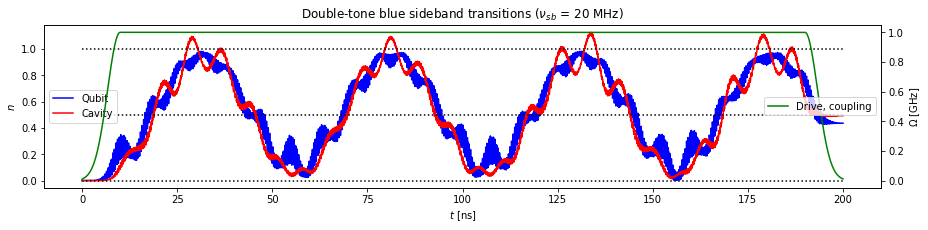

In [31]:
""" EXPECTATION VALUES """

fig, ax1 = plt.subplots(figsize=[15,3])
ax1.plot(times, expect[0], color='b', label='Qubit')
ax1.plot(times, expect[1], color='r', label='Cavity')
ax1.plot([times[0], times[-1]], [1, 1], ':', color='k')
ax1.plot([times[0], times[-1]], [1/2, 1/2], ':', color='k')
ax1.plot([times[0], times[-1]], [0, 0], ':', color='k')
ax1.set_xlabel("$t$ [ns]")
ax1.set_ylabel("$n$")
ax1.tick_params(axis='y')
ax1.legend(loc='center left')

# ax1.set_xlim([20, 21])

if Nt == 1:
    drive_coupling = wd/(2*pi)*drive_nonosc(times, H_args)
elif Nt == 2:
    drive_coupling = drive_nonosc(times, H_args)
ax2 = ax1.twinx()
ax2.plot(times, drive_coupling, color='g', label='Drive, coupling')
ax2.set_ylabel('$\Omega$ [GHz]')
ax2.tick_params(axis='y')
ax2.legend(loc='center right')

fig = plt.gcf()
if sb == 'red':
    if Nt == 1:
        plt.title("Single-tone red sideband transitions at $\\nu_d$ = {} GHz ($\\nu_{{sb}}$ = {} MHz)".format(
                  round(wd/2/pi, 3), int(round(1000*wsb/2/pi))))
    elif Nt == 2:
        plt.title("Double-tone red sideband transitions ($\\nu_{{sb}}$ = {} MHz)".format(
                  int(round(1000*wsb/2/pi))))
elif sb == 'blue':
    if Nt == 1:
        plt.title("Single-tone blue sideband transitions at $\\nu_d$ = {} GHz ($\\nu_{{sb}}$ = {} MHz)".format(
                  round(wd/2/pi, 3), int(round(1000*wsb/2/pi))))
    elif Nt == 2:
        plt.title("Double-tone blue sideband transitions ($\\nu_{{sb}}$ = {} MHz)".format(
                  int(round(1000*wsb/2/pi))))
plt.show()

figqc_button = widgets.Button(description='Save figure')
figqc_out = widgets.Output()
def figqc_clicked(b):
    figqc_button.description = 'Figure saved!'
    with figqc_out:
        if Nt == 1:
            fig.savefig(srcfolder + "/" +
                        "fig_qc_{}_{}_Nq{}_Nt{}_Om{}_wd{}_wq{}_wc{}_g{}_wsb{}.png".format(ID, sb, Nq, Nt,
                        round(Omega/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2),
                        round(g/2/pi, 2), round(wsb/2/pi, 4)), bbox_inches='tight')
        elif Nt == 2:
            fig.savefig(srcfolder + "/" +
                        "fig_qc_{}_{}_Nq{}_Nt{}_Omq{}_wdq{}_Omc{}_wdc{}_wq{}_wc{}_g{}_wsb{}.png".format(
                        ID, sb, Nq, Nt, round(Omegaq/2/pi, 2), round(wdq/2/pi, 3), round(Omegac/2/pi, 2),
                        round(wdc/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2),
                        round(g/2/pi, 2), round(wsb/2/pi, 4)), bbox_inches='tight')
figqc_button.on_click(figqc_clicked)
widgets.VBox([figqc_button, figqc_out])

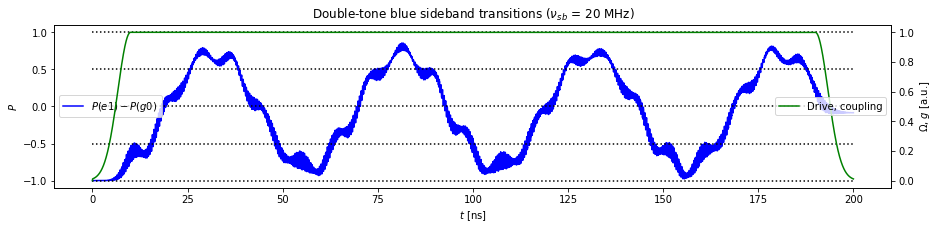

In [29]:
"""COMBINED PROBABILITIES"""

fig, ax1 = plt.subplots(figsize=[15,3])
if sb == 'red':
    ax1.plot(times, e0-g1, color='r', label='$P(e0) - P(g1)$')
if sb == 'blue':
    ax1.plot(times, e1-g0, color='b', label='$P(e1) - P(g0)$')
ax1.plot([times[0], times[-1]], [1, 1], ':', color='k')
ax1.plot([times[0], times[-1]], [1/2, 1/2], ':', color='k')
ax1.plot([times[0], times[-1]], [0, 0], ':', color='k')
ax1.plot([times[0], times[-1]], [-1/2, -1/2], ':', color='k')
ax1.plot([times[0], times[-1]], [-1, -1], ':', color='k')
ax1.set_xlabel("$t$ [ns]")
ax1.set_ylabel("$P$")
ax1.tick_params(axis='y')
ax1.legend(loc='center left')

# ax1.set_xlim([40, 50])

ax2 = ax1.twinx()
if Nt == 1:
    drive_coupling = wd/(2*pi)*drive_nonosc(times, H_args)
    ax2.set_ylabel('$\Omega$, $g$ [GHz]')
elif Nt == 2:
    drive_coupling = drive_nonosc(times, H_args)
    ax2.set_ylabel('$\Omega$, $g$ [a.u.]')
ax2.plot(times, drive_coupling, color='g', label='Drive, coupling')
ax2.tick_params(axis='y')
ax2.legend(loc='center right')

fig = plt.gcf()
if sb == 'red':
    if Nt == 1:
        plt.title("Single-tone red sideband transitions at $\\nu_d$ = {} GHz ($\\nu_{{sb}}$ = {} MHz)".format(
                  round(wd/2/pi, 3), int(round(1000*wsb/2/pi))))
    elif Nt == 2:
        plt.title("Double-tone red sideband transitions ($\\nu_{{sb}}$ = {} MHz)".format(
                  int(round(1000*wsb/2/pi))))
elif sb == 'blue':
    if Nt == 1:
        plt.title("Single-tone blue sideband transitions at $\\nu_d$ = {} GHz ($\\nu_{{sb}}$ = {} MHz)".format(
                  round(wd/2/pi, 3), int(round(1000*wsb/2/pi))))
    elif Nt == 2:
        plt.title("Double-tone blue sideband transitions ($\\nu_{{sb}}$ = {} MHz)".format(
                  int(round(1000*wsb/2/pi))))
plt.show()

fig_button = widgets.Button(description='Save figure')
fig_out = widgets.Output()
def fig_clicked(b):
    fig_button.description = 'Figure saved!'
    with fig_out:
        if Nt == 1:
            fig.savefig(srcfolder + "/" +
                        "fig_{}_{}_Nq{}_Nt{}_Om{}_wd{}_wq{}_wc{}_g{}_wsb{}.png".format(ID, sb, Nq, Nt,
                        round(Omega/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2),
                        round(g/2/pi, 2), round(wsb/2/pi, 4)), bbox_inches='tight')
        elif Nt == 2:
            fig.savefig(srcfolder + "/" +
                        "fig_{}_{}_Nq{}_Nt{}_Omq{}_wdq{}_Omc{}_wdc{}_wq{}_wc{}_g{}_wsb{}.png".format(
                        ID, sb, Nq, Nt, round(Omegaq/2/pi, 2), round(wdq/2/pi, 3), round(Omegac/2/pi, 2),
                        round(wdc/2/pi, 3), round(wq/2/pi, 2), round(wc/2/pi, 2),
                        round(g/2/pi, 2), round(wsb/2/pi, 4)), bbox_inches='tight')
fig_button.on_click(fig_clicked)
widgets.VBox([fig_button, fig_out])

In [ ]:
"""SCANNING (single tone)"""
# WDs = np.linspace(1.326*2*pi, 1.328*2*pi, 21)  # drive freq range to scan
# for WD in WDs:
#     sample_single_tone(Nq, wq, wc, WD, smooth, Q, t0, t1, t2, t3, tg, psi0, Np_per_batch, options)

0.0


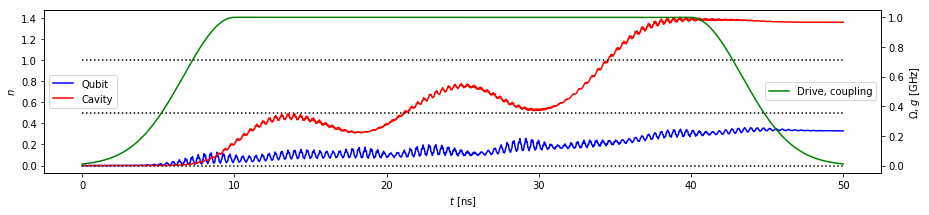

0.01


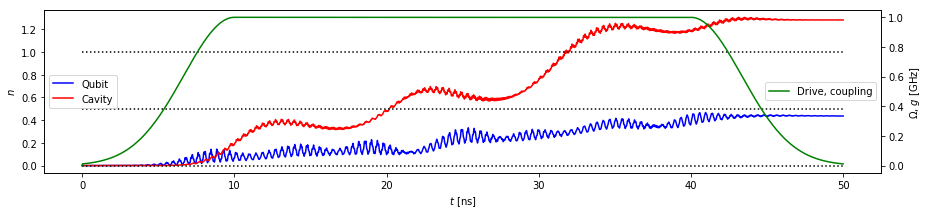

0.02


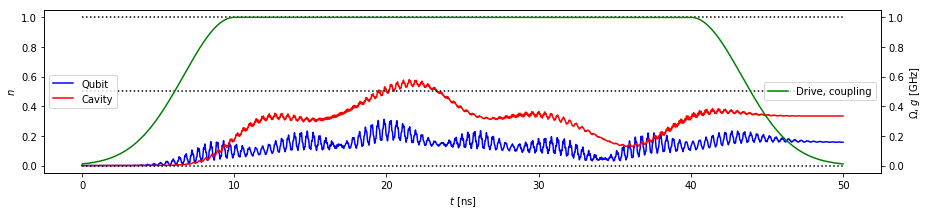

0.03


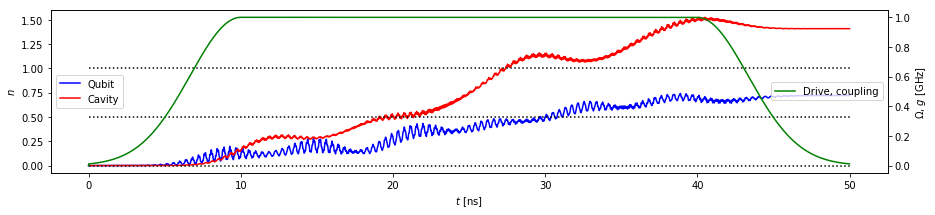

0.04


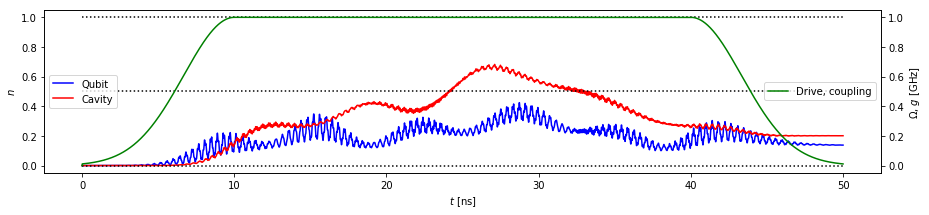

0.05


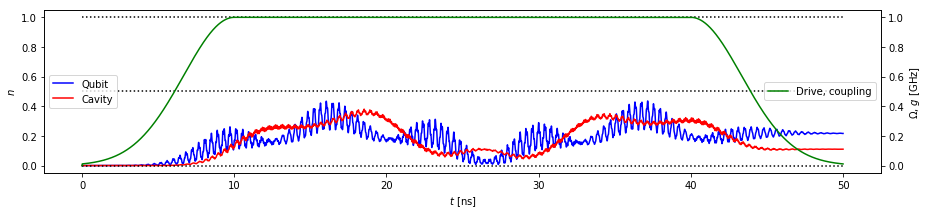

0.06


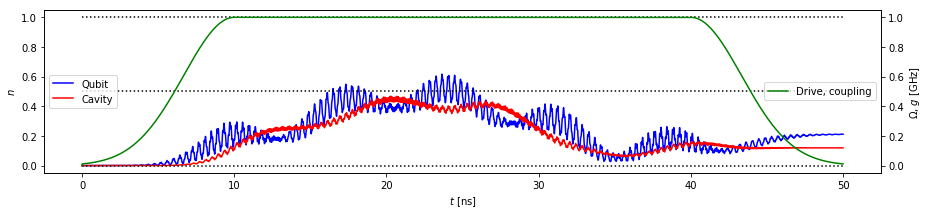

0.07


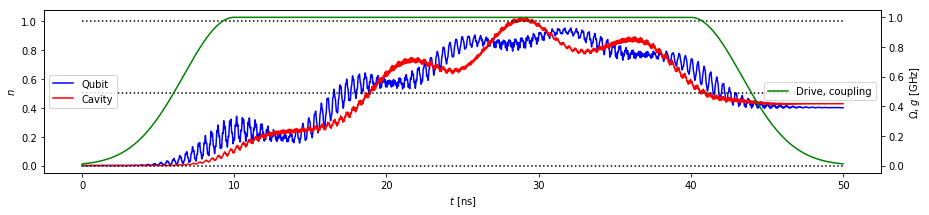

0.08


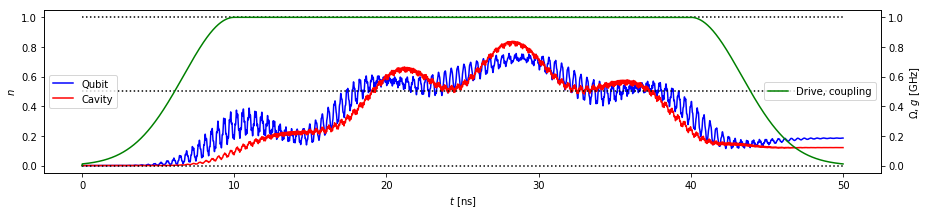

0.09


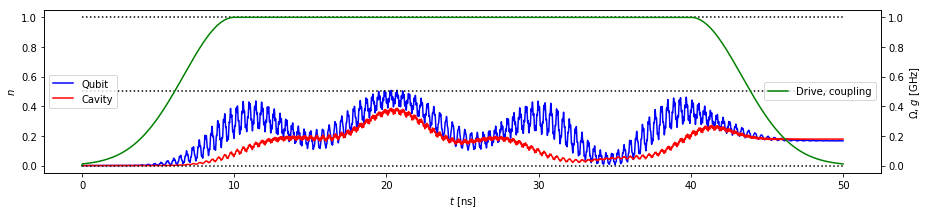

0.1


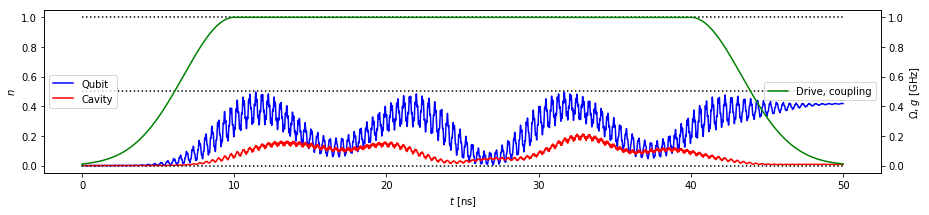

0.11


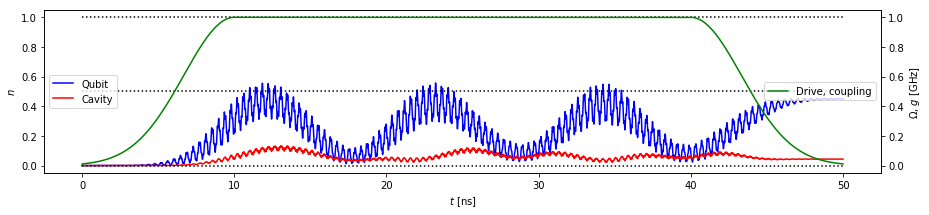

0.12


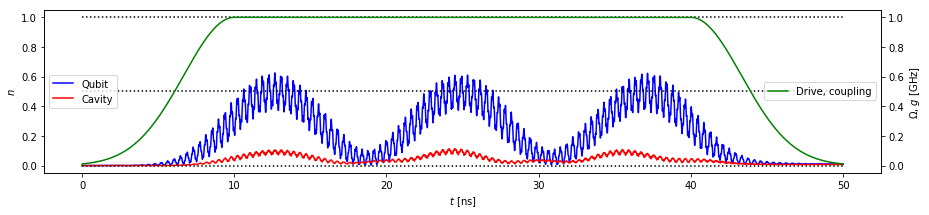

0.13


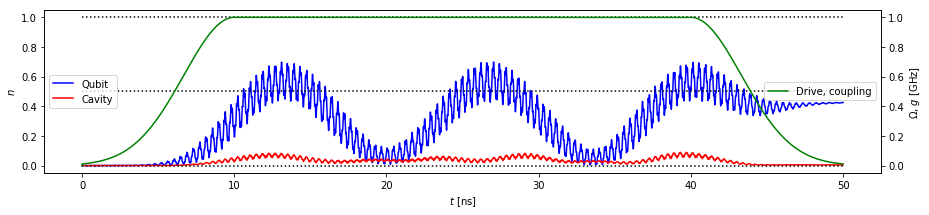

0.14


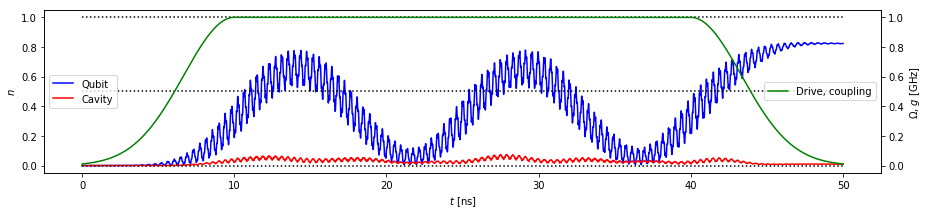

0.15


In [ ]:
"""SCANNING (double tone)"""
fshifts = np.linspace(0.0*2*pi, 0.50*2*pi, 51)  # ac-Stark shift range to scan
for fshift in fshifts:
    sample_double_tone(Nq, wq, wc, fshift, dw, sb, smooth, Q, t0, t1, t2, t3, tg, psi0, Np_per_batch, options)